In [ ]:
#Age of patient at time of operation (numerical)
#Patient's year of operation (year - 1900, numerical)
#Number of positive axillary nodes detected (numerical)
#Survival status (class attribute)
#1 = the patient survived 5 years or longer
#2 = the patient died within 5 year


In [3]:
import pandas as pd
import numpy as np

# Assuming 'data.csv' is your CSV file
df = pd.read_csv('haberman.csv')

# Separate the features and the target variable

X = df[['Age', 'YearOfOPP', 'Nodes']].to_numpy()
y = df['Survival']

# Convert the species labels to integers
species_to_int = {species: idx for idx, species in enumerate(np.unique(y))}
y_int = np.array([species_to_int[survival] for survival in y])

# Optionally, convert the integer labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = len(species_to_int)
y_one_hot = one_hot_encode(y_int, num_classes)


In [4]:
import torch
# Convert to PyTorch tensors
x_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_one_hot, dtype=torch.float32)

In [44]:
num_cut = [1,1]  
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 2
d = X.shape[1]
print(X.shape, y.shape, d, num_cut, num_leaf, num_class)

(306, 3) (306,) 3 [1, 1] 4 2


In [45]:
# Initialize variables
cut_points_list = [torch.nn.Parameter(torch.rand(i)) for i in num_cut]
leaf_score = torch.nn.Parameter(torch.rand(num_leaf, num_class))

# Define loss and optimizer
optimizer = torch.optim.Adam([*cut_points_list, leaf_score], lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.CrossEntropyLoss()

In [46]:
from pytorch_neural import nn_decision_tree
# Training loop
for i in range(1000):
    optimizer.zero_grad()
    y_pred = nn_decision_tree(x_tensor, cut_points_list, leaf_score, temperature=0.1)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(loss.item())

0.6319634914398193
0.5779217481613159
0.5779219269752502
0.5779217481613159
0.5779219269752502


In [47]:
# Evaluate
with torch.no_grad():
    y_pred_eval = nn_decision_tree(x_tensor, cut_points_list, leaf_score, temperature=0.1)
    error_rate = 1 - (y_pred_eval.argmax(1) == y_tensor.argmax(1)).float().mean()
    print('error rate %.2f' % error_rate)

error rate 0.26


In [48]:
from sklearn.metrics import accuracy_score

y_pred = nn_decision_tree(x_tensor, cut_points_list, leaf_score, temperature=0.1)
accuracy_score(y_tensor.argmax(1), y_pred.argmax(1))
print(accuracy_score(y_tensor.argmax(1), y_pred.argmax(1)))

0.7352941176470589


In [49]:
sample_x0 = np.repeat(np.linspace(0, np.max(X[:,0]), 100), 100).reshape(-1,1)
sample_x1 = np.tile(np.linspace(0, np.max(X[:,1]), 100).reshape(-1,1), [100,1])
sample_x = np.hstack([sample_x0, sample_x1])
sample_x_tensor = torch.tensor(sample_x, dtype=torch.float32)

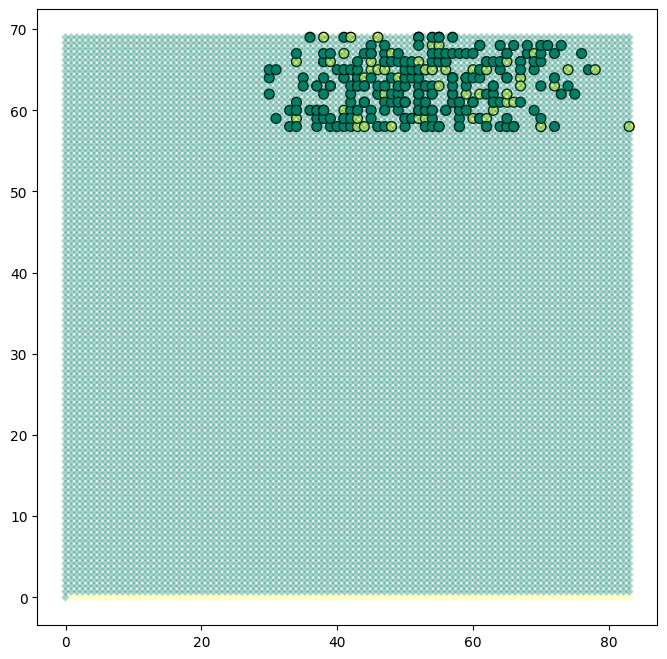

In [50]:
import matplotlib.pyplot as plt
with torch.no_grad():
    sample_label = nn_decision_tree(sample_x_tensor, cut_points_list, leaf_score, temperature=0.1).argmax(1)

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=np.argmax(y_one_hot, axis=1), marker='o', s=50, cmap='summer', edgecolors='black')
plt.scatter(sample_x0.flatten(), sample_x1.flatten(), c=sample_label.numpy().flatten(), marker='D', s=20, cmap='summer', edgecolors='none', alpha=0.33)
plt.show()